<a href="https://colab.research.google.com/github/Ron256/SimmilarityOfXRDData/blob/main/simmilarityOfXRDVer2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [333]:
import numpy as np
import scipy.io as spio
import sys
import math
import plotly.graph_objects as go
np.set_printoptions(threshold=sys.maxsize)

import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline')
plt.style.use('ggplot')

In [334]:
!pip install ipyvolume
import ipyvolume as ipv
from scipy.signal import find_peaks
import numpy as np
import sys
import matplotlib.pyplot as plt
from numpy import percentile
import pandas as pd
import math
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
!pip install yellowbrick
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.cluster import KMeans
from scipy.spatial import distance
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import SpectralClustering
import statistics
from statistics import mean, stdev
# from matching.games import StableMarriage
from scipy.spatial.distance import directed_hausdorff
from sklearn.preprocessing import MinMaxScaler
# import ternary
import plotly.graph_objects as go
import json
from IPython.display import HTML
from sklearn import metrics


In [335]:
'''Trains a Siamese MLP on pairs of digits from the MNIST dataset.
It follows Hadsell-et-al.'06 [1] by computing the Euclidean distance on the
output of the shared network and by optimizing the contrastive loss (see paper
for mode details).
# References
- Dimensionality Reduction by Learning an Invariant Mapping
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
Gets to 97.2% test accuracy after 20 epochs.
2 seconds per epoch on a Titan X Maxwell GPU
'''
from __future__ import absolute_import
from __future__ import print_function

import random
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda
#!pip install RMSprop
#from keras.optimizers import RMSprop
#!pip install SDG
import tensorflow as tf

from tensorflow.keras import optimizers

from keras import backend as K

num_classes = 5
epochs = 10

In [336]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    uses y_true as Y and y_pred as the Euclidean distance between dissimilar points
    '''
    margin = 1
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')

    sqaure_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * sqaure_pred + (1 - y_true) * margin_square)

#def create_pairs(x, digit_indices):
#    '''Positive and negative pair creation.
#    Alternates between positive and negative pairs.
#    '''
#    pairs = []
#    labels = []
#    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
#    for d in range(num_classes):
#        for i in range(n):
#            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
#            pairs += [[x[z1], x[z2]]]
#            inc = random.randrange(1, num_classes)
#            dn = (d + inc) % num_classes
#            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
#            pairs += [[x[z1], x[z2]]]
#            labels += [1, 0]
#    return np.array(pairs), np.array(labels)

def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    # print('input_shape  : %s' %(str(input_shape)))
    ## check if input is the length of the array, length of signal. 
    input = Input(shape=input_shape)
    x = (input)
    #print('First Flattening : %s' %(str(x.shape)))
    # Run the code with my signals
    # they used to go from 784 to 128
    # determine if I need to 256?
    x = Dense(128, activation='relu')(x)
    # print('1 First Dense : %s' %(str(x)))
    x = Dropout(0.1)(x)
    # print('1 First Dropout : %s' %(str(x)))
    x = Dense(128, activation='relu')(x)
    #print('2 second dense : %s' %(str(x)))
    x = Dropout(0.1)(x)
    # print('2 second Dropout : %s' %(str(x)))
    x = Dense(128, activation='relu')(x)
    # print('2 second dense : %s' %(str(x)))
    x = Lambda(lambda  x: K.l2_normalize(x,axis=1))(x)
    x = Lambda(lambda  x: K.l2_normalize(x,axis=1))(x)
    return Model(input, x)

def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

# Using TensorFlow backend

In [337]:

def generatePosNegPairs(mergedL_without_duplicates, similar):
  """Function that returns a list of generated signals with assigned labels"""

  signalsL = []
  labels = []
  for num in range(len(mergedL_without_duplicates)):
    if 'similar' == similar:
      # access the positive signals using the generated pair of indicies
      signal_pair = coordinate_list[mergedL_without_duplicates[num][0]], coordinate_list[mergedL_without_duplicates[num][1]]

      # convert the tuple into numpy array
      signal_pair_arr = np.asarray(signal_pair).astype(np.float32)
      print('shape of  signal_pair_arr: %s' %str((signal_pair_arr.shape)))

      # for debugging purposes
      # print('type of signal_pair : %s' %type(signal_pair))
      # signalsLabels_L = [signal_pair, 1]

      # add the list of signal labels to the list 
      # signalsL.append(signalsLabels_L)
      signalsL.append((signal_pair_arr, np.asarray(1).astype(np.float32)))
    else:
      # access the negative signals using the generated pair of indicies
      signal_pair = coordinate_list[mergedL_without_duplicates[num][0]], coordinate_list[mergedL_without_duplicates[num][1]]
      
      # convert the tuple into a numpy array
      signalsLabels_arr = np.asarray(signal_pair).astype(np.float32)

      print('shape of  signalsLabels_arr: %s' %(str(signalsLabels_arr.shape)))
      # signalsLabels_L = [signal_pair, 0]

      # for debugging purposes
      # print('type of signalsLabels_L : %s' %type(signalsLabels_L))

      # add the list of signal labels to the list 
      # signalsL.append(signalsLabels_L)
      signalsL.append((signalsLabels_arr, np.asarray(0).astype(np.float32)))

    # return the list
  return signalsL

In [338]:

def generateUnique(listofLabels):
  """Function that returns a unique number of a list"""
  labels_numpy = np.array(listofLabels)

  return (np.unique(labels_numpy))

In [339]:
# Parse Bunn and Long label files of FeGaPd dataset: returns a dictionary of the form: {8: [1, 2, 9, ...], 9: [3, 4, 5 ...], 10: [14, 16, 17, ...]...}
def parse_label_file(label_file_path):
    label_list = []
    label_file = open(label_file_path)
    lines = label_file.readlines()
    for line in lines:
        stripped_line = line.rstrip('\n')
        label_list.append(int(stripped_line))
    label_file.close()
    
    clusterSamples = {}
   
    for sample_idx in range(len(label_list)):
        sample_number = sample_idx + 1
        cluster_number = label_list[sample_idx]
        
        if (cluster_number not in clusterSamples):
            clusterSamples[cluster_number] = [sample_number]
        else:
            clusterSamples[cluster_number].append(sample_number)
    return clusterSamples

In [340]:
# Plots normalized ternary plot for fegapd dataset
# compositions is a list of lists of all compositions
def plot_ternary_fegapd(compositions, clusters, highlighted_clusters = None): 
    max_fe = max([c[0] for c in compositions])
    max_ga = max([c[1] for c in compositions])
    max_pd = max([c[2] for c in compositions])
    
    min_fe = min([c[0] for c in compositions])
    min_ga = min([c[1] for c in compositions])
    min_pd = min([c[2] for c in compositions])
    
    normalized_comps = []
    for composition in compositions:
        concentration_sum = 0
        Fe = float(composition[0])
        Ga = float(composition[1])
        Pd = float(composition[2])
        concentration_sum = Fe+Ga+Pd
        if concentration_sum < 99:
            print(concentration_sum)
            normalized_comps.append([composition[0], composition[1], composition[2]])
        else:
            normalized_comps.append([math.ceil((float(composition[0])/max_fe)*100), 
                                     math.ceil((float(composition[1])/max_ga)*100), 
                                     math.ceil((float(composition[2])/max_pd)*100)])
    fig = go.Figure()
    colors = ['dodgerblue','yellow', 'red', 'darkblue', 'deeppink', 'black', 'lime', 'cyan', 'lightsteelblue', 'orange', 'silver', 'chocolate']
   
    for color_idx, idx in enumerate(clusters):
        cluster_comps = [compositions[sample_nr-1] for sample_nr in clusters[idx]]
       
        fe_comps = [c[0] for c in cluster_comps]
        ga_comps = [c[1] for c in cluster_comps]
        pd_comps = [c[2] for c in cluster_comps]
        
        if(highlighted_clusters is None):
            color=colors[color_idx % len(colors)]
        else:
            if(idx in highlighted_clusters):
                color = ['red', 'green'][highlighted_clusters.index(idx) % 2]
            else:
                color = 'gray'
        fig.add_traces(go.Scatterternary(a=fe_comps, b=ga_comps, c=pd_comps, mode='markers', marker=go.scatterternary.Marker(color=color), text= f"Cluster {idx}"))
        
    
    fig.update_ternaries(sum=100,aaxis_min= max(min_fe - 5, 0), baxis_min = max(min_ga - 5, 0), caxis_min= max(min_pd - 5, 0))

    fig.update_layout({
        'title': 'Ternary Scatterplot',
        'ternary':
            {
            'sum':100,
            'aaxis':{'title': '<b>Fe</b>'},
            'baxis':{'title': '<b>Ga</b>'},
            'caxis':{'title': '<b>Pd</b>'}
        },
        'showlegend': False
    })
    # # fig.show()
    return fig


In [341]:
# Plots normalized ternary plot for fegapd dataset
# compositions is a list of lists of all compositions
def plot_ternary_fegapd(compositions, clusters, highlighted_clusters = None): 
    max_fe = max([c[0] for c in compositions])
    max_ga = max([c[1] for c in compositions])
    max_pd = max([c[2] for c in compositions])
    
    min_fe = min([c[0] for c in compositions])
    min_ga = min([c[1] for c in compositions])
    min_pd = min([c[2] for c in compositions])
    
    normalized_comps = []
    for composition in compositions:
        concentration_sum = 0
        Fe = float(composition[0])
        Ga = float(composition[1])
        Pd = float(composition[2])
        concentration_sum = Fe+Ga+Pd
        if concentration_sum < 99:
            print(concentration_sum)
            normalized_comps.append([composition[0], composition[1], composition[2]])
        else:
            normalized_comps.append([math.ceil((float(composition[0])/max_fe)*100), 
                                     math.ceil((float(composition[1])/max_ga)*100), 
                                     math.ceil((float(composition[2])/max_pd)*100)])
    fig = go.Figure()
    colors = ['dodgerblue','yellow', 'red', 'darkblue', 'deeppink', 'black', 'lime', 'cyan', 'lightsteelblue', 'orange', 'silver', 'chocolate']
   
    for color_idx, idx in enumerate(clusters):
        cluster_comps = [compositions[sample_nr-1] for sample_nr in clusters[idx]]
       
        fe_comps = [c[0] for c in cluster_comps]
        ga_comps = [c[1] for c in cluster_comps]
        pd_comps = [c[2] for c in cluster_comps]
        
        if(highlighted_clusters is None):
            color=colors[color_idx % len(colors)]
        else:
            if(idx in highlighted_clusters):
                color = ['red', 'green'][highlighted_clusters.index(idx) % 2]
            else:
                color = 'gray'
        fig.add_traces(go.Scatterternary(a=fe_comps, b=ga_comps, c=pd_comps, mode='markers', marker=go.scatterternary.Marker(color=color), text= f"Cluster {idx}"))
        
    
    fig.update_ternaries(sum=100,aaxis_min= max(min_fe - 5, 0), baxis_min = max(min_ga - 5, 0), caxis_min= max(min_pd - 5, 0))

    fig.update_layout({
        'title': 'Ternary Scatterplot',
        'ternary':
            {
            'sum':100,
            'aaxis':{'title': '<b>Fe</b>'},
            'baxis':{'title': '<b>Ga</b>'},
            'caxis':{'title': '<b>Pd</b>'}
        },
        'showlegend': False
    })
    # # fig.show()
    return fig


In [342]:
# Plots each sample in a cluster on the same graph for fegapd dataset
def plotOnSameGraph_2(samples, clusterNum, coordinate_list):
    xcpost = coordinate_list[0]
    _, ax1 = plt.subplots()
    ax1.set_xlabel('Angle')
    ax1.set_ylabel('Intensity')
    ax1.set_title('Post Background Removal: Cluster ' + str(clusterNum))
    ax1.set_ylim([0, 1400])
    
    for sample in samples:
        y1 = coordinate_list[sample]
        # print('y1 : %s' %str(y1))
        y1Arr = np.asarray(y1).astype(float)
        ax1.plot(xcpost, y1Arr)

# mount the drive

In [343]:
# mount the drive
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


# Load data from Matlab file for FeGaPd

In [344]:
# this data set has the disagreements whether the methodology in this case is applied
temp = spio.loadmat('/gdrive/MyDrive/CSC695/datasets/FeGaPd_XRD_200714a.mat')
print('temp is : %s', type(temp))
cmp = temp['C']
xy = temp['XY'] # these are the coordinates where these samples are physically located .
X = temp['X'] # y coordinates of the XRD data
T = temp['T'] # this is a list of list with the x coordinates. 
labels_col = temp['labels_col']

# print(temp)
# What is the meaning of FeGAPd? Is Fe, Ga, Pd different columns
# print('labels_cols : %s' %(type(labels_col)))

temp is : %s <class 'dict'>


## Composition percentages

In [345]:
# Percentages of all the samples
print(cmp)
#print(len(cmp))
#print(type(cmp)) # There are 278 samples in this pacrticular data set. each of these should be 278

[[0.8216 0.1285 0.0499]
 [0.8286 0.1164 0.055 ]
 [0.8435 0.1006 0.0559]
 [0.852  0.0922 0.0559]
 [0.8556 0.0702 0.0742]
 [0.8476 0.0792 0.0732]
 [0.8442 0.0878 0.068 ]
 [0.8386 0.0954 0.066 ]
 [0.8288 0.1092 0.062 ]
 [0.8189 0.1213 0.0598]
 [0.8033 0.138  0.0587]
 [0.794  0.152  0.054 ]
 [0.7768 0.172  0.0512]
 [0.7579 0.1945 0.0476]
 [0.7031 0.2531 0.0438]
 [0.7247 0.2265 0.0488]
 [0.7431 0.2022 0.0546]
 [0.7584 0.184  0.0575]
 [0.7684 0.1677 0.0639]
 [0.7857 0.1481 0.0662]
 [0.7994 0.1286 0.072 ]
 [0.8084 0.1153 0.0762]
 [0.8124 0.1081 0.0795]
 [0.824  0.0942 0.0818]
 [0.8302 0.084  0.0858]
 [0.8379 0.0739 0.0882]
 [0.8421 0.0667 0.0912]
 [0.8478 0.0588 0.0935]
 [0.8319 0.0587 0.1094]
 [0.8286 0.0624 0.109 ]
 [0.821  0.0711 0.1079]
 [0.8146 0.079  0.1064]
 [0.8152 0.0847 0.1001]
 [0.8069 0.0973 0.0958]
 [0.7962 0.111  0.0928]
 [0.787  0.1246 0.0884]
 [0.7788 0.1397 0.0815]
 [0.7636 0.1592 0.0771]
 [0.7524 0.1756 0.0721]
 [0.739  0.1969 0.0641]
 [0.7166 0.2224 0.061 ]
 [0.7062 0.2401 

## Wafer coordinates

In [346]:
#print(xy) # these are actual coordinates where the samples are on, it is like around overal  material
print(len(xy)) # these are the coordinates where these samples are physically located .

278


## x coordinates of XRD data

In [347]:
# Displaying the first 5 elements of the X coordinates. 
T[0][1:5] 

array([24.42, 24.44, 24.46, 24.48])

In [348]:
print(T[0][1:5]) # a list of list which has the x-coordinate because the data is in angles and intensity
print(len(T[0])) # it is an array of one single data 
# these are the amount of coordinate features. 

[24.42 24.44 24.46 24.48]
1616


## y coordinates of XRD data

In [349]:
print('X is %s' %type(X))
print(len(X[277])) # 
print(X[277])
#print(len(X[0]))

#print(X[277])
#print(len(X[277])) # y coordinates are labelled as x which is confusing but that is how they are labelled.

X is <class 'numpy.ndarray'>
1616
[9.6544275e+00 1.1446881e+01 1.0782087e+01 1.2551042e+01 1.6147529e+01
 1.1323971e+01 7.6019642e+00 5.8317502e+00 3.1659735e+01 1.2978075e+01
 1.1170245e+01 2.0478543e+01 2.1857790e+01 1.6538656e+01 1.9920485e+01
 2.9890254e+01 1.5710512e+01 6.8052707e-01 5.9419920e+00 1.3792467e+01
 4.9567566e+00 1.0800431e+01 7.4625491e+00 0.0000000e+00 4.0574356e+00
 1.6157201e+01 2.3065884e+01 1.9144505e+01 1.4169562e+01 0.0000000e+00
 6.3440793e-01 4.3608787e-01 7.2518026e+00 1.3593156e+01 7.7844105e+00
 1.1677770e+01 4.4647467e+00 2.3331740e+01 2.7942172e+01 1.3471650e+00
 7.5908550e-01 2.3817945e+00 2.8505600e+01 1.5837532e+01 1.9944820e+01
 1.8632288e+01 1.7883183e+01 1.2790627e+01 6.7571124e-01 0.0000000e+00
 1.7796899e+01 5.8874946e+00 6.1370115e+00 3.0790483e+01 3.8584519e+01
 2.4695969e+01 4.7715248e+00 2.1054075e+01 2.4365145e+01 3.6877830e+01
 2.7298873e+01 9.0818015e+00 5.3398761e+00 8.0239557e+00 3.0448222e+00
 1.4364527e+01 3.1697099e+01 2.7186207e+01 

## Visualize ternary plots and layered graphs for Long and Bunn labels

In [350]:
# Draw ternary scatterplot with Bunn Labels
# already know ground truth
bunn_labels = parse_label_file("/gdrive/MyDrive/CSC695/datasets/FeGaPd-Bunn.txt")
# bunn_labels 
compositions = [[c[0]*100, c[1]*100, c[2]*100] for c in cmp]
plot_ternary_fegapd(compositions, bunn_labels)

In [351]:
# Draw ternary scatterplot with Long Labels
long_labels = parse_label_file("/gdrive/MyDrive/CSC695/datasets/FeGaPd-Long.txt")
#long_labels
# compositions is a list of lists of all compositions
plot_ternary_fegapd(compositions, long_labels)

# Prepare data for pre-processing and plotting

In [352]:
# List of XRD coordinates of form: [[x], [y1], [y2]...] - for plotting purposes
coordinate_list =   [list(T[0])] + [list(l) for l in X] # [list(l) for l in X]
# coordinate_list
# Returns a turple of lists in the form ([x coords], [[sample 1 y coords], [sample 2 y coords]...]) for pre-processing purposes
coordinate_list_preprocessing = (list(T[0]), [list(l) for l in X])
# coordinate_list_preprocessing

# Visualize sample signals with ground truth labels

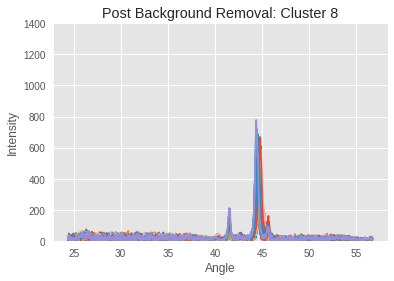

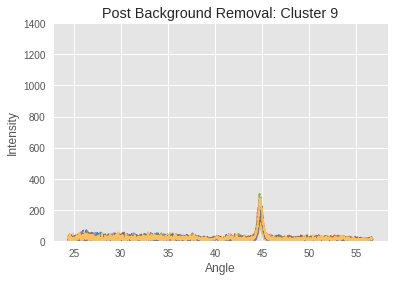

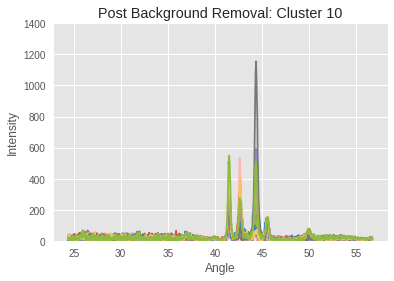

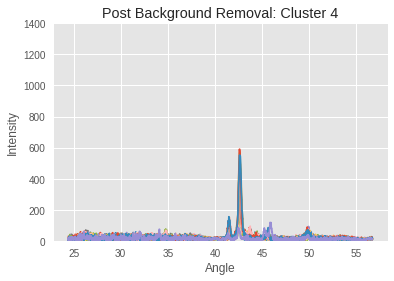

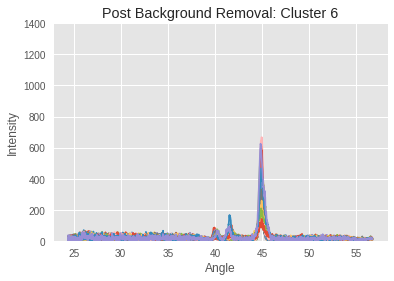

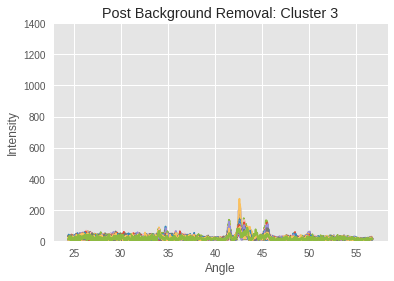

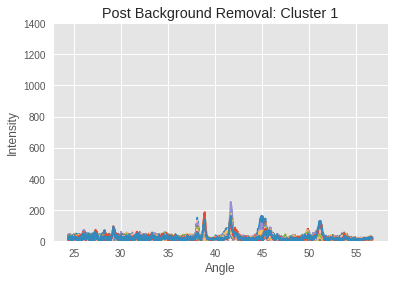

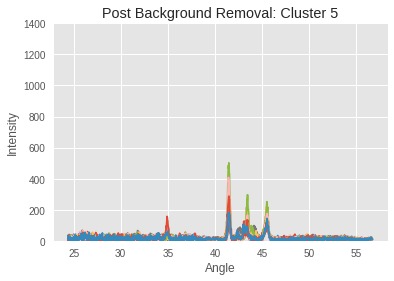

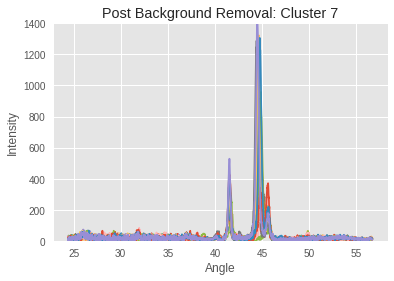

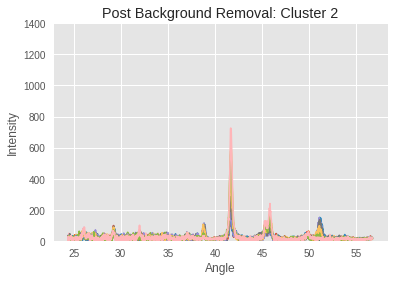

In [353]:
# 10 cluster ground truth
bunn_labels = parse_label_file("/gdrive/MyDrive/CSC695/datasets/FeGaPd-Bunn.txt")
# bunn_labels
for cluster in bunn_labels:
  #print(cluster)
  plotOnSameGraph_2(bunn_labels[cluster], cluster, coordinate_list)

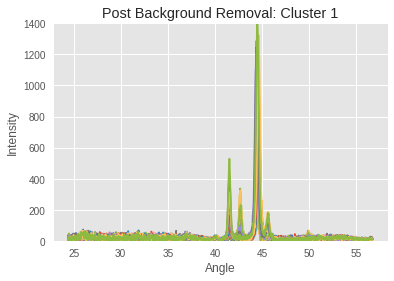

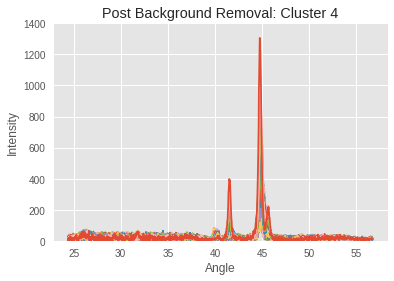

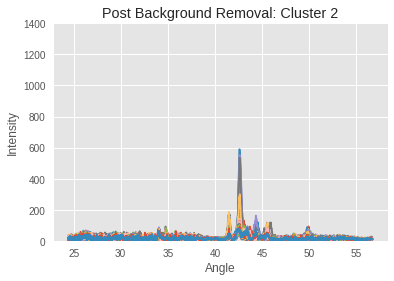

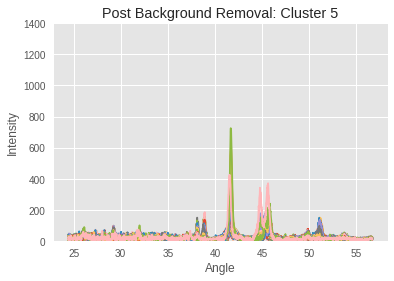

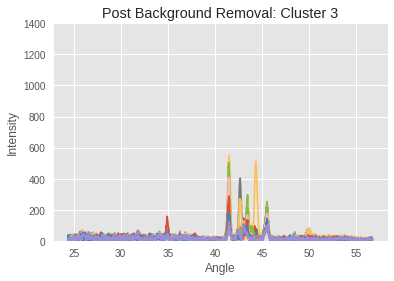

In [354]:
# 5 cluster ground truth
for cluster in long_labels:
    plotOnSameGraph_2(long_labels[cluster], cluster, coordinate_list)
# we are using a 5 cluster ground truth. 

# Distribution of the class labels using Histogram.

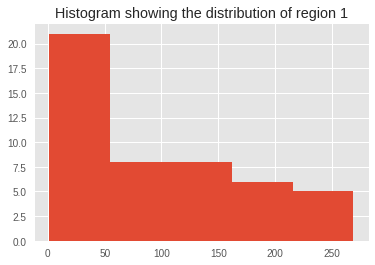

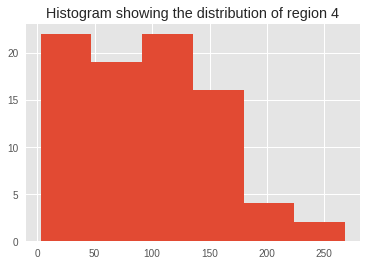

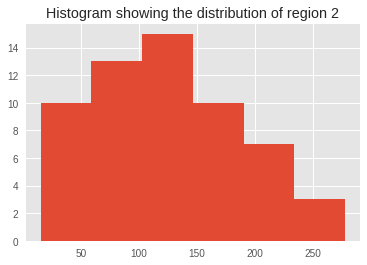

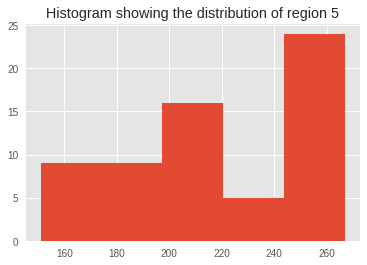

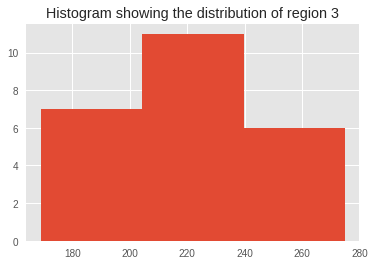

In [355]:
for region in long_labels.keys():
  n_dist = pd.Series(long_labels[region])

  IQR = (n_dist.quantile(0.75) -  n_dist.quantile(0.25))
  bin_width = (2 * IQR)/(len(n_dist) ** (1/3))  
  binWidth = int(np.ceil((n_dist.max() - n_dist.min()) / bin_width))
  # plot the histogram
  plt.hist(long_labels[region], bins=binWidth)

  plt.title('Histogram showing the distribution of region ' + str(region))
  plt.show()
  print('\n')

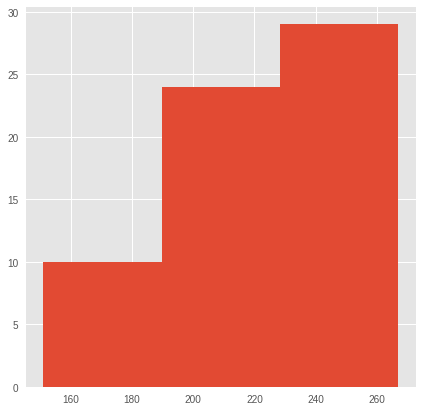

In [356]:
bin_count = int(np.ceil(np.log2(len(n_dist))) + 1)
# histogram of long_labels[2]
fig = plt.figure(figsize=(7,7))
plt.hist(long_labels[5], bins=binWidth)
plt.show()

In [357]:
binWidth

3

In [358]:
num_of_classes = 5

In [359]:
def create_pairs(coordinate_list, s_indices):
  """ 
  Function that creates Positive and negative pairs.
  """
  pairs = []
  labels = []
  n = min([len(s_indices[d]) for d in range(num_of_classes)]) - 1
  # n = 23
  for d in range(num_of_classes):
    for i in range(n):
      z1, z2 = s_indices[d][i], s_indices[d][i+1]
      #print(z1, z2)
      pairs += [[coordinate_list[z1], coordinate_list[z2]]]
      #print('pairs : %s' %pairs)
      #print(len(pairs))

      inc = random.randrange(1, num_of_classes)
      #print('inc : %s' %inc)
      dn = (d + inc) % num_of_classes
      z1, z2 = s_indices[d][i], s_indices[d][i] 
      pairs += [[coordinate_list[z1], coordinate_list[z2]]]
      labels += [1, 0]
  return np.array(pairs), np.array(labels)

In [360]:
# create training + test positive and negative pairs
# s_indices = [value for key, value in long_labels.items()]
# signalL_pairs, tr_y = create_pairs(coordinate_list, s_indices)
# input_shape = signalL_pairs.shape
# input_shape

In [361]:
# print(tr_y.shape)

# Creation of negative pairs

In [362]:
# Method 2
# Phase_1_5
used_pairs_1_5_D = {}
for num in range(201):
  # randomly pick index from phase 1, randomly pick index from phase 2
  index_1 = random.sample(long_labels[1], 1) 

  index_2 = random.sample(long_labels[2], 1) 
  
  pairs1_2L = [index_1[0], index_2[0]]
  pairs1_2 = tuple(sorted(pairs1_2L))

  # randomly pick index from phase 1, randomly pick index from phase 3
  index_3 = random.sample(long_labels[3], 1) 
  pairs1_3L = [index_1[0], index_3[0]]
  pairs1_3 = tuple(sorted(pairs1_3L))

  # randomly pick index from phase 1, randomly pick index from phase 4
  index_4 = random.sample(long_labels[4], 1) 
  pairs1_4L = [index_1[0], index_4[0]]
  pairs1_4 = tuple(sorted(pairs1_4L))

  # randomly pick index from phase 1, randomly pick index from phase 5
  index_5 = random.sample(long_labels[5], 1) 
  pairs1_5L = [index_1[0], index_5[0]]
  pairs1_5 = tuple(sorted(pairs1_5L))

  
  # ignoring duplicates
  if pairs1_2 not in used_pairs_1_5_D.keys():
    used_pairs_1_5_D[pairs1_2] = pairs1_2
    
  if pairs1_3 not in used_pairs_1_5_D.keys():
    used_pairs_1_5_D[pairs1_3] = pairs1_3

  if pairs1_4 not in used_pairs_1_5_D.keys():
    used_pairs_1_5_D[pairs1_4] = pairs1_4

  if pairs1_5 not in used_pairs_1_5_D.keys():
    used_pairs_1_5_D[pairs1_5] = pairs1_5
print(used_pairs_1_5_D)


{(91, 174): (91, 174), (91, 170): (91, 170), (72, 91): (72, 91), (91, 189): (91, 189), (73, 224): (73, 224), (73, 221): (73, 221), (30, 73): (30, 73), (73, 151): (73, 151), (19, 121): (19, 121), (19, 220): (19, 220), (19, 58): (19, 58), (19, 265): (19, 265), (10, 129): (10, 129), (10, 170): (10, 170), (10, 67): (10, 67), (10, 253): (10, 253), (186, 276): (186, 276), (186, 234): (186, 234), (144, 186): (144, 186), (186, 190): (186, 190), (225, 237): (225, 237), (232, 237): (232, 237), (63, 237): (63, 237), (237, 249): (237, 249), (13, 177): (13, 177), (13, 181): (13, 181), (13, 187): (13, 187), (13, 197): (13, 197), (79, 90): (79, 90), (90, 170): (90, 170), (90, 141): (90, 141), (90, 192): (90, 192), (37, 49): (37, 49), (37, 183): (37, 183), (37, 145): (37, 145), (37, 267): (37, 267), (121, 166): (121, 166), (166, 222): (166, 222), (59, 166): (59, 166), (166, 208): (166, 208), (18, 277): (18, 277), (18, 219): (18, 219), (18, 66): (18, 66), (18, 196): (18, 196), (52, 227): (52, 227), (52

In [363]:
print(len(used_pairs_1_5_D))

768


In [364]:
# Phase_2_5
used_pairs_2_5 = set()
used_pairs_2_5_D = {}
for num in range(201):
  # randomly pick index from phase 2, randomly pick index from phase 3
  index_2 = random.sample(long_labels[2], 1) 

  index_3 = random.sample(long_labels[3], 1) 
             # helper function that defines the given pairs and returns back a tuple. 
  pairs2_3L =[index_2[0], index_3[0]]

  # convert the list to a tuple
  pairs2_3 = tuple(sorted(pairs2_3L))

  # randomly pick index from phase 2, randomly pick index from phase 4
  index_4 = random.sample(long_labels[4], 1) 
  pairs2_4L = [index_2[0], index_4[0]]

  # convert the list to a tuple
  pairs2_4 = tuple(sorted(pairs2_4L))

  # randomly pick index from phase 2, randomly pick index from phase 5
  index_5 = random.sample(long_labels[5], 1) 
  pairs2_5L = [index_2[0], index_5[0]]

  # convert the list to a tuple
  pairs2_5 = tuple(sorted(pairs2_5L))

  # convert the list to a tuple
  pairs = tuple(sorted(pairs2_4L))


  # ignoring duplicates
  if pairs2_3 not in used_pairs_2_5_D.keys():
    used_pairs_2_5_D[pairs2_3] = pairs2_3

  if pairs2_4 not in used_pairs_2_5_D.keys():
    used_pairs_2_5_D[pairs2_4] = pairs2_4
    
  if pairs2_5 not in used_pairs_2_5_D.keys():
    used_pairs_2_5_D[pairs2_5] = pairs2_5

print(len(used_pairs_2_5_D))

578


In [365]:
# Phase_3_5
used_pairs_3_5_D = {}
for num in range(201):
  # randomly pick index from phase 3, randomly pick index from phase 4
  index_3 = random.sample(long_labels[3], 1) 

  index_4 = random.sample(long_labels[4], 1) 
             
  pairs3_4L = [index_3[0], index_4[0]]
  #print(pairs3_4L)

  # convert the list to a tuple
  pairs = tuple(sorted(pairs3_4L))
  
  # ignoring duplicates#
  if pairs not in used_pairs_3_5_D.keys():
    used_pairs_3_5_D[pairs] = pairs

  # randomly pick index from phase 3, randomly pick index from phase 5
  index_5 = random.sample(long_labels[5], 1) 
  pairs3_5L = [index_3[0], index_5[0]]

  # convert the list to a tuple
  pairs = tuple(sorted(pairs3_5L))

  # ignoring duplicates#
  if pairs not in used_pairs_3_5_D.keys():
    used_pairs_3_5_D[pairs] = pairs
    
print(len(used_pairs_3_5_D))

379


In [366]:
# phase_4_5
used_pairs_4_5 = set()
used_pairs_4_5_D = {}
cnt=1
for num in range(201):
  # randomly pick index from phase 4, randomly pick index from phase 5
  index_4 = random.sample(long_labels[4], 1) 


  index_5 = random.sample(long_labels[5], 1) 
        
  pairs4_5L = [index_4[0], index_5[0]]
  
  # convert the list to a tuple
  pairs = tuple(sorted(pairs4_5L))
  
  # ignoring duplicates#
  if pairs not in used_pairs_4_5_D.keys():
    used_pairs_4_5_D[pairs] = pairs
  #  pass
  #else:
  #  used_pairs_4_5_D[pairs] = pairs

print(len(used_pairs_4_5_D))


200


In [367]:
mergedList = list(used_pairs_1_5_D.values()) + list(used_pairs_2_5_D.values()) + list(used_pairs_3_5_D.values()) + list(used_pairs_4_5_D.values())
# double check to make sure that there are no duplicates
mergedL_without_duplicates = [num_pairs for num_pairs in (set(tuple(item) for item in mergedList))]
print('The total number of negative pairs is %s.' %len(mergedL_without_duplicates))

The total number of negative pairs is 1925.


In [368]:
mergedL_without_duplicates[255]

(83, 117)

# Creation of positive pairs

In [369]:
positive_pairs_D = {}

In [370]:

def drivePositivePairs(dictKey, num):
  """Function that randomly picks two number indexes from a dictionary key and inserts them into a dictionary of positive pairs"""
  pairs_num = random.sample(dictKey, num)

  # convert the list to a tuple
  pairs_num = tuple(sorted(pairs_num))

  if pairs_num not in positive_pairs_D.keys():
    positive_pairs_D[pairs_num]= pairs_num

  return None


In [371]:
for num in range(401):
  # randomly pick 2 indexes from phase 1
  drivePositivePairs(long_labels[1], 2)

  # randomly pick 2 indexes from phase 2
  drivePositivePairs(long_labels[2], 2)

  # randomly pick 2 indexes from phase 3
  drivePositivePairs(long_labels[3], 2)

  # randomly pick 2 indexes from phase 4
  drivePositivePairs(long_labels[4], 2)

  # randomly pick 2 indexes from phase 5
  drivePositivePairs(long_labels[5], 2)
print(len(positive_pairs_D))

1655


In [372]:
# lets extract out the positive pairs into a list
positive_pairs_L = list(positive_pairs_D.values())
print('The number of positive pairs of indicies is %s.' %len(positive_pairs_L))

The number of positive pairs of indicies is 1655.


In [373]:
# type(positive_pairs_L[0])

In [374]:
# we generate pairs of negative signals using the generated pair of negative indicies.
negativeSignal_pairs= generatePosNegPairs(mergedL_without_duplicates, 'dissimilar')
print('The number of generated negative pairs of signals is %s.\n' %len(negativeSignal_pairs))

shape of  signalsLabels_arr: (2, 1616)
shape of  signalsLabels_arr: (2, 1616)
shape of  signalsLabels_arr: (2, 1616)
shape of  signalsLabels_arr: (2, 1616)
shape of  signalsLabels_arr: (2, 1616)
shape of  signalsLabels_arr: (2, 1616)
shape of  signalsLabels_arr: (2, 1616)
shape of  signalsLabels_arr: (2, 1616)
shape of  signalsLabels_arr: (2, 1616)
shape of  signalsLabels_arr: (2, 1616)
shape of  signalsLabels_arr: (2, 1616)
shape of  signalsLabels_arr: (2, 1616)
shape of  signalsLabels_arr: (2, 1616)
shape of  signalsLabels_arr: (2, 1616)
shape of  signalsLabels_arr: (2, 1616)
shape of  signalsLabels_arr: (2, 1616)
shape of  signalsLabels_arr: (2, 1616)
shape of  signalsLabels_arr: (2, 1616)
shape of  signalsLabels_arr: (2, 1616)
shape of  signalsLabels_arr: (2, 1616)
shape of  signalsLabels_arr: (2, 1616)
shape of  signalsLabels_arr: (2, 1616)
shape of  signalsLabels_arr: (2, 1616)
shape of  signalsLabels_arr: (2, 1616)
shape of  signalsLabels_arr: (2, 1616)
shape of  signalsLabels_a

In [375]:
# we generate pairs of positive signals using the generated pairs of positive indicies.
positiveSignals_pairs = generatePosNegPairs(positive_pairs_L, 'similar')
print('The number of generated positive pairs of signals is %s.\n' %len(positiveSignals_pairs))

shape of  signal_pair_arr: (2, 1616)
shape of  signal_pair_arr: (2, 1616)
shape of  signal_pair_arr: (2, 1616)
shape of  signal_pair_arr: (2, 1616)
shape of  signal_pair_arr: (2, 1616)
shape of  signal_pair_arr: (2, 1616)
shape of  signal_pair_arr: (2, 1616)
shape of  signal_pair_arr: (2, 1616)
shape of  signal_pair_arr: (2, 1616)
shape of  signal_pair_arr: (2, 1616)
shape of  signal_pair_arr: (2, 1616)
shape of  signal_pair_arr: (2, 1616)
shape of  signal_pair_arr: (2, 1616)
shape of  signal_pair_arr: (2, 1616)
shape of  signal_pair_arr: (2, 1616)
shape of  signal_pair_arr: (2, 1616)
shape of  signal_pair_arr: (2, 1616)
shape of  signal_pair_arr: (2, 1616)
shape of  signal_pair_arr: (2, 1616)
shape of  signal_pair_arr: (2, 1616)
shape of  signal_pair_arr: (2, 1616)
shape of  signal_pair_arr: (2, 1616)
shape of  signal_pair_arr: (2, 1616)
shape of  signal_pair_arr: (2, 1616)
shape of  signal_pair_arr: (2, 1616)
shape of  signal_pair_arr: (2, 1616)
shape of  signal_pair_arr: (2, 1616)
s

In [376]:
negativeSignal_pairs[0][0]

array([[2.1653009e+01, 1.1593545e+01, 1.8002920e+01, 2.6738859e+01,
        1.1239617e+01, 1.8490679e+01, 1.3414504e+01, 2.1058807e+01,
        2.1058220e+01, 5.9535990e+00, 0.0000000e+00, 1.2494610e+01,
        2.2158049e+01, 6.4603634e+00, 1.2677795e+00, 1.0121845e+01,
        2.4616781e+01, 2.5109957e+01, 1.5456088e+01, 2.2968279e+01,
        0.0000000e+00, 1.2345427e+00, 6.6057696e+00, 3.4159155e+00,
        2.0383387e+01, 0.0000000e+00, 1.2141317e+01, 1.0598885e+01,
        0.0000000e+00, 8.9181328e+00, 1.6239933e+01, 7.8609014e+00,
        0.0000000e+00, 1.9988077e+01, 2.6421127e+01, 1.9194189e+01,
        8.0114555e+00, 2.1622513e+01, 2.2261097e+01, 8.2523994e+00,
        1.1850212e+01, 3.6271832e+00, 1.6941540e+01, 2.7516949e+01,
        1.6402966e+01, 2.5662212e+01, 2.8188728e+01, 1.7669238e+00,
        7.0618181e+00, 2.0712364e+01, 1.2655510e+01, 1.8787842e+01,
        9.3460827e+00, 8.1947660e+00, 3.5491920e+00, 2.0961714e+01,
        3.1140224e+01, 1.0522285e+01, 2.8493820e

In [377]:
# let's modify the data structure
def modifyNegPosSignals(negativeSignal_pairs):
  """Function that transposes the individual tuple of signals, extracts out the labels and returns a list of transformed positive or negative signals"""
  negposSignal_pairs = []
  for i in range(len(negativeSignal_pairs)):
    transposedItems = negativeSignal_pairs[i][0].transpose()
    # print(transposedItems[:, 1], transposedItems[:, 1], negativeSignal_pairs[i][1])
    negposSignal_pairs.append((transposedItems[:, 1], transposedItems[:, 1], negativeSignal_pairs[i][1]))
    
  return negposSignal_pairs

In [378]:
# use a helper function to modify the negative signals
negativeSignal_modified_pairs = modifyNegPosSignals(negativeSignal_pairs)
negativeSignal_modified_pairs_arr = np.asarray(negativeSignal_modified_pairs, dtype='object')
# negativeSignal_modified_pairs_arr[:, 2]

In [379]:
# negativeSignal_modified_pairs_arr[:, 2]

In [380]:
# use a helper function to modify the positive signals
positiveSignals_modified_pairs = modifyNegPosSignals(positiveSignals_pairs) 
positiveSignals_modified_pairs_arr = np.asarray(positiveSignals_modified_pairs, dtype='object')
positiveSignals_modified_pairs_arr[:, 2]

array([array(1., dtype=float32), array(1., dtype=float32),
       array(1., dtype=float32), array(1., dtype=float32),
       array(1., dtype=float32), array(1., dtype=float32),
       array(1., dtype=float32), array(1., dtype=float32),
       array(1., dtype=float32), array(1., dtype=float32),
       array(1., dtype=float32), array(1., dtype=float32),
       array(1., dtype=float32), array(1., dtype=float32),
       array(1., dtype=float32), array(1., dtype=float32),
       array(1., dtype=float32), array(1., dtype=float32),
       array(1., dtype=float32), array(1., dtype=float32),
       array(1., dtype=float32), array(1., dtype=float32),
       array(1., dtype=float32), array(1., dtype=float32),
       array(1., dtype=float32), array(1., dtype=float32),
       array(1., dtype=float32), array(1., dtype=float32),
       array(1., dtype=float32), array(1., dtype=float32),
       array(1., dtype=float32), array(1., dtype=float32),
       array(1., dtype=float32), array(1., dtype=float32

# Create a data frame of signals and labels.

In [381]:
# create a pandas DataFrame having the contents of the positive Signal pairs
Pos_df = pd.DataFrame(data=positiveSignals_modified_pairs_arr, columns=['signal0', 'signal1', 'labels'])
Pos_df.head()

,signal0,signal1,labels
0,"[21.65301, 11.593545, 18.00292, 26.73886, 11.2...","[21.65301, 11.593545, 18.00292, 26.73886, 11.2...",1.0
1,"[7.293912, 9.467498, 20.96946, 10.204902, 17.3...","[7.293912, 9.467498, 20.96946, 10.204902, 17.3...",1.0
2,"[17.162788, 33.210804, 17.702482, 7.5459137, 1...","[17.162788, 33.210804, 17.702482, 7.5459137, 1...",1.0
3,"[12.597891, 7.5332046, 10.697223, 22.99977, 9....","[12.597891, 7.5332046, 10.697223, 22.99977, 9....",1.0
4,"[17.050041, 8.08504, 8.052471, 25.13068, 10.82...","[17.050041, 8.08504, 8.052471, 25.13068, 10.82...",1.0


In [382]:
# create a pandas DataFrame having the contents of the negative Signal pairs
neg_df = pd.DataFrame(data=negativeSignal_modified_pairs_arr, columns=['signal0', 'signal1', 'labels'])
neg_df.head()

,signal0,signal1,labels
0,"[10.836974, 28.272936, 33.491768, 13.956242, 1...","[10.836974, 28.272936, 33.491768, 13.956242, 1...",0.0
1,"[13.730826, 34.524097, 18.415749, 17.90871, 22...","[13.730826, 34.524097, 18.415749, 17.90871, 22...",0.0
2,"[14.425905, 14.728751, 0.0, 0.0, 10.237183, 29...","[14.425905, 14.728751, 0.0, 0.0, 10.237183, 29...",0.0
3,"[0.0, 7.9692836, 17.182684, 7.434907, 14.02923...","[0.0, 7.9692836, 17.182684, 7.434907, 14.02923...",0.0
4,"[0.46758968, 21.494005, 8.883517, 12.353576, 9...","[0.46758968, 21.494005, 8.883517, 12.353576, 9...",0.0


In [383]:
# concatenate the positive and negative signal pairs along rows
signals_df = pd.concat([Pos_df, neg_df], axis=0)

In [384]:
# shape of the data frame
signals_df.shape

(3580, 3)

In [385]:
# meta data of the DataFrame
signals_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3580 entries, 0 to 1924
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   signal0  3580 non-null   object
 1   signal1  3580 non-null   object
 2   labels   3580 non-null   object
dtypes: object(3)
memory usage: 111.9+ KB


In [386]:
# display the first 5 records of the signals data frame
signals_df.head()

,signal0,signal1,labels
0,"[21.65301, 11.593545, 18.00292, 26.73886, 11.2...","[21.65301, 11.593545, 18.00292, 26.73886, 11.2...",1.0
1,"[7.293912, 9.467498, 20.96946, 10.204902, 17.3...","[7.293912, 9.467498, 20.96946, 10.204902, 17.3...",1.0
2,"[17.162788, 33.210804, 17.702482, 7.5459137, 1...","[17.162788, 33.210804, 17.702482, 7.5459137, 1...",1.0
3,"[12.597891, 7.5332046, 10.697223, 22.99977, 9....","[12.597891, 7.5332046, 10.697223, 22.99977, 9....",1.0
4,"[17.050041, 8.08504, 8.052471, 25.13068, 10.82...","[17.050041, 8.08504, 8.052471, 25.13068, 10.82...",1.0


In [387]:
# display the last 5 records of the signals data frame.
signals_df.tail()

,signal0,signal1,labels
1920,"[10.172726, 20.754335, 20.88851, 27.250599, 8....","[10.172726, 20.754335, 20.88851, 27.250599, 8....",0.0
1921,"[19.400824, 5.5453486, 21.655, 10.381272, 14.4...","[19.400824, 5.5453486, 21.655, 10.381272, 14.4...",0.0
1922,"[18.730688, 0.0, 5.056399, 7.3126836, 20.37692...","[18.730688, 0.0, 5.056399, 7.3126836, 20.37692...",0.0
1923,"[0.0, 11.615263, 10.3958, 8.204173, 0.0, 0.0, ...","[0.0, 11.615263, 10.3958, 8.204173, 0.0, 0.0, ...",0.0
1924,"[0.0, 11.615263, 10.3958, 8.204173, 0.0, 0.0, ...","[0.0, 11.615263, 10.3958, 8.204173, 0.0, 0.0, ...",0.0


In order to minimise the variance and ensure that the model will generalise well to new, unseen data points we shuffle the data frame as shown below:

In [388]:
# in order to reproduce the results, we set a random seed of numpy.
np.random.seed(100)

# shuffle the data set's rows.
# using the reset_index method to reset the index of the returned DataFrame.
signals_df_sh = signals_df.sample(frac=1).reset_index(drop=True)

In [389]:
# shape of the data frame
signals_df_sh.shape

(3580, 3)

In [390]:
# displaying  the first 20 records of the shuffled signals data frame
signals_df_sh.head(20)

,signal0,signal1,labels
0,"[13.932329, 12.681331, 12.874885, 15.79093, 26...","[13.932329, 12.681331, 12.874885, 15.79093, 26...",1.0
1,"[5.0309114, 12.475575, 10.530827, 2.8754225, 9...","[5.0309114, 12.475575, 10.530827, 2.8754225, 9...",0.0
2,"[12.205672, 3.419878, 23.156998, 14.892471, 14...","[12.205672, 3.419878, 23.156998, 14.892471, 14...",1.0
3,"[19.86578, 14.9725, 7.700839, 17.665857, 19.70...","[19.86578, 14.9725, 7.700839, 17.665857, 19.70...",1.0
4,"[11.920876, 1.3190058, 6.5798435, 1.1690263, 2...","[11.920876, 1.3190058, 6.5798435, 1.1690263, 2...",1.0
5,"[20.401691, 11.86693, 16.075817, 4.5072107, 14...","[20.401691, 11.86693, 16.075817, 4.5072107, 14...",0.0
6,"[21.733341, 13.81696, 31.873339, 17.90251, 7.2...","[21.733341, 13.81696, 31.873339, 17.90251, 7.2...",1.0
7,"[19.368673, 13.522989, 24.677916, 21.96538, 20...","[19.368673, 13.522989, 24.677916, 21.96538, 20...",0.0
8,"[9.654428, 11.446881, 10.782087, 12.551042, 16...","[9.654428, 11.446881, 10.782087, 12.551042, 16...",0.0
9,"[5.0309114, 12.475575, 10.530827, 2.8754225, 9...","[5.0309114, 12.475575, 10.530827, 2.8754225, 9...",1.0


In [391]:
# displaying  the last 20 records of the shuffled signals data frame
signals_df_sh.tail(20)

,signal0,signal1,labels
3560,"[9.187512, 13.167873, 16.923592, 4.5795603, 11...","[9.187512, 13.167873, 16.923592, 4.5795603, 11...",0.0
3561,"[10.085679, 8.246286, 19.548273, 12.191802, 17...","[10.085679, 8.246286, 19.548273, 12.191802, 17...",1.0
3562,"[17.789745, 20.061872, 21.264917, 8.529242, 22...","[17.789745, 20.061872, 21.264917, 8.529242, 22...",0.0
3563,"[19.86578, 14.9725, 7.700839, 17.665857, 19.70...","[19.86578, 14.9725, 7.700839, 17.665857, 19.70...",0.0
3564,"[10.212613, 0.0, 0.0, 14.269648, 16.542173, 14...","[10.212613, 0.0, 0.0, 14.269648, 16.542173, 14...",0.0
3565,"[22.904835, 12.333465, 3.4191763, 5.957719, 8....","[22.904835, 12.333465, 3.4191763, 5.957719, 8....",1.0
3566,"[0.0, 8.067483, 20.58959, 20.567099, 22.682709...","[0.0, 8.067483, 20.58959, 20.567099, 22.682709...",0.0
3567,"[7.1866794, 8.97465, 7.7288933, 9.951874, 11.0...","[7.1866794, 8.97465, 7.7288933, 9.951874, 11.0...",1.0
3568,"[12.743222, 11.932491, 9.322926, 7.410508, 12....","[12.743222, 11.932491, 9.322926, 7.410508, 12....",1.0
3569,"[20.053516, 13.325768, 13.768085, 9.94401, 20....","[20.053516, 13.325768, 13.768085, 9.94401, 20....",1.0


In [392]:
# separate the labels from the shuffled signals data frame
y = signals_df_sh['labels']
y.shape

(3580,)

In [393]:
# drop the labels from the shuffled signals data frame
X = signals_df_sh.drop(['labels'], axis=1)
X.shape

(3580, 2)

# Reshaping the X data frame

In [394]:
X.shape

(3580, 2)

In [395]:
X_data = np.array(X)
X_data.shape

(3580, 2)

# lets randomly select 70% of the shuffled negative and positive signal pairs for training and remaining 30% for testing.

In [396]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.3, random_state=42)

In [397]:
# shape of the X_train data set
X_train.shape

(2506, 2)

In [398]:
# shape of the y_train data set
y_train.shape

(2506,)

In [399]:
# shape of X_test data set
X_test.shape

(1074, 2)

In [400]:
# shape of the y_test data set
y_test.shape

(1074,)

# lets convert the data frame and series to numpy array

In [401]:
# type(X_train)
# X=np.asarray(X).astype(np.float32)


In [403]:
numL

[]

In [404]:
X_train_arr = np.asarray(X_train)

In [405]:
# X_train_arr = tf.convert_to_tensor(X_train_arr, dtype=tf.float32)

In [406]:
# len(X_train_arr[:, 1])

In [407]:
y_train_arr = np.asarray(y_train)

In [408]:
X_test_arr = np.asarray(X_test)

In [409]:
y_test_arr = np.asarray(y_test)

# network definition

In [410]:
# convert apandas data frame into a list
# X_trainL = X_train.values.tolist()
# len(X_trainL)

In [411]:
#X_trainModifiedL = []
# for i in range(len(X_trainL)):
#  modifiedI = [np.asarray(X_trainL[i]), np.asarray(X_trainL[i])]
#  X_trainModifiedL.append(modifiedI)

In [412]:
# X_trainModified_arr = np.asarray(X_trainModifiedL)

In [413]:
# X_trainModified_arr.shape

In [414]:
# convert a pandas testing data frame into a list
#X_testL = X_test.values.tolist()

In [415]:
#X_testModifiedL = []
#for i in range(len(X_testL)):
#  modofiedI = [np.asarray(X_testL[i]), np.asarray(X_testL[i])]
# X_testModifiedL.append(modifiedI)

In [416]:
# X_testModified_arr = np.asarray(X_testModifiedL)
# X_testModified_arr[:, 1]

In [417]:
# size of the signal
input_shape = X_train.shape[1]
print('input_shape : %s' %input_shape)

base_network = create_base_network(input_shape)
# commented out
input_a = Input(shape=input_shape)
print('input_a : %s' %input_a)
input_b = Input(shape=input_shape)
print('input_b : %s' %input_b)


# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
# commented out when testing
processed_a = base_network(input_a)
processed_b = base_network(input_b)
print('processed_a : %s'%processed_a)
print('processed_b : %s'%processed_b)

# commented out when testing
distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])
#print(distance)

model = Model([input_a, input_b], distance) # think we are shaping our model. 

# train
# commented out
#rms = optimizers. RMSprop()
rms = optimizers.Adam()
#rms = SGD()

#### change back to rms??? wouldn't load in library
model.compile(loss=contrastive_loss, optimizer='adam', metrics=[accuracy])
# train the model

history = model.fit([X_train_arr[:, 0], X_train_arr[:, 1]], y_train_arr,
          batch_size=128,
         epochs=epochs,
          validation_data=([X_test_arr[:, 0][:], X_test_arr[:, 1][:]], y_test_arr))

input_shape : 2
input_a : KerasTensor(type_spec=TensorSpec(shape=(None, 2), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")
input_b : KerasTensor(type_spec=TensorSpec(shape=(None, 2), dtype=tf.float32, name='input_3'), name='input_3', description="created by layer 'input_3'")
processed_a : KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='model/lambda_1/l2_normalize:0', description="created by layer 'model'")
processed_b : KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='model/lambda_1/l2_normalize:0', description="created by layer 'model'")


ValueError: ignored

In [418]:
xt0 = X_train_arr[:, 0][0]
xt0


array([6.5171270e+00, 1.6505136e+00, 7.0526295e+00, 0.0000000e+00,
       4.0116372e+00, 1.0419883e+00, 9.6813726e-01, 1.1603486e+01,
       0.0000000e+00, 0.0000000e+00, 1.1781701e+01, 1.3742412e+01,
       2.9000828e+01, 1.6718096e+01, 0.0000000e+00, 2.3815056e+01,
       1.3075384e+01, 0.0000000e+00, 2.3844238e+01, 2.7344053e+01,
       1.7405093e-01, 1.1731171e+01, 1.5371977e+01, 1.5949419e+01,
       1.6093365e+01, 0.0000000e+00, 1.4558242e+01, 1.7253393e+01,
       1.1338122e+01, 0.0000000e+00, 1.5648475e+01, 2.4945757e+01,
       6.6647768e+00, 7.1092911e+00, 1.2863003e+01, 2.1038919e+01,
       6.0750861e+00, 2.6968670e+01, 3.3937996e+01, 5.1467228e+00,
       1.3099026e+01, 1.7379616e+01, 1.3530179e+01, 2.8146465e+01,
       3.0855537e+01, 2.4773493e+01, 1.8297632e+01, 1.5611146e+01,
       3.4158707e+01, 1.6455763e+01, 5.0810113e+00, 1.3746998e+01,
       1.5675839e+01, 2.0583948e+01, 7.8432102e+00, 1.9101084e+01,
       1.4462751e+01, 2.8088812e+01, 2.8940125e+01, 1.3681775e

In [419]:
X_train_arr.shape

(2506, 2)

In [420]:
xt1 = X_train_arr[:, 1][0]
xt1

array([6.5171270e+00, 1.6505136e+00, 7.0526295e+00, 0.0000000e+00,
       4.0116372e+00, 1.0419883e+00, 9.6813726e-01, 1.1603486e+01,
       0.0000000e+00, 0.0000000e+00, 1.1781701e+01, 1.3742412e+01,
       2.9000828e+01, 1.6718096e+01, 0.0000000e+00, 2.3815056e+01,
       1.3075384e+01, 0.0000000e+00, 2.3844238e+01, 2.7344053e+01,
       1.7405093e-01, 1.1731171e+01, 1.5371977e+01, 1.5949419e+01,
       1.6093365e+01, 0.0000000e+00, 1.4558242e+01, 1.7253393e+01,
       1.1338122e+01, 0.0000000e+00, 1.5648475e+01, 2.4945757e+01,
       6.6647768e+00, 7.1092911e+00, 1.2863003e+01, 2.1038919e+01,
       6.0750861e+00, 2.6968670e+01, 3.3937996e+01, 5.1467228e+00,
       1.3099026e+01, 1.7379616e+01, 1.3530179e+01, 2.8146465e+01,
       3.0855537e+01, 2.4773493e+01, 1.8297632e+01, 1.5611146e+01,
       3.4158707e+01, 1.6455763e+01, 5.0810113e+00, 1.3746998e+01,
       1.5675839e+01, 2.0583948e+01, 7.8432102e+00, 1.9101084e+01,
       1.4462751e+01, 2.8088812e+01, 2.8940125e+01, 1.3681775e

In [422]:
array = np.array([[1,2,3],[3,4,5],[5,6,7]])
print("This is a numpy array:")
print(array, array.shape, type(array))

This is a numpy array:
[[1 2 3]
 [3 4 5]
 [5 6 7]] (3, 3) <class 'numpy.ndarray'>


In [423]:
array.shape

(3, 3)

# Convert to tensor

In [424]:
v_tensor = tf.convert_to_tensor(array)
v_tensor

<tf.Tensor: shape=(3, 3), dtype=int64, numpy=
array([[1, 2, 3],
       [3, 4, 5],
       [5, 6, 7]])>

In [425]:
def con_ten(convert_func):
  convert_func = tf.convert_to_tensor(convert_func, dtype=tf.int32)
  
  return convert_func

In [426]:
first_value = con_ten(tf.constant([[1,2,3,4],[5,6,7,8]]))
print(first_value)

tf.Tensor(
[[1 2 3 4]
 [5 6 7 8]], shape=(2, 4), dtype=int32)


In [427]:
# checking if all items of the list are of the same length
X_trainL = X_train.values.tolist()
numL = []
for i in range(len(X_trainL)):
  numSize = X_trainL[i][0]
  if numSize.size != 1616:
    numL.append(numSize.size)




In [428]:
numL

[]